# Random Forest Regression for Rogue Wave Prediction

In this notebook, we model rogue wave characteristics using a Random Forest regression model. A Random Forest is an ensemble learning method that builds multiple decision trees and aggregates their outputs to make predictions. Each tree is trained on a random subset of the data and features, which helps reduce variance and overfitting. This makes Random Forests particularly powerful for handling non-linear relationships, feature interactions, and noisy or high-dimensional data.

Unlike linear models, Random Forests do not require feature scaling. Since decision trees split data based on thresholds rather than optimizing a continuous function, the model is inherently scale-invariant, meaning features do not need to be standardized before training. 

Hyperparameter tuning is performed using k-fold cross-validation with a stratified splitting strategy. Stratification ensures that the rare rogue wave events are well represented in each fold, which is important for stable performance evaluation and fair training-validation distribution.

We tune the following hyperparameters to optimize model performance while keeping memory usage feasible for downstream SHAP analysis:
- `n_estimators = 100`: This sets the number of trees in the ensemble. We limit this to 100 to balance performance and model size, as larger forests increase memory usage significantly.
- `max_depth = [10, 20, 30]`: This parameter controls the maximum depth of each decision tree. Deeper trees can model more complex patterns but also risk overfitting. The selected range allows flexibility while keeping the trees interpretable and memory-efficient.
- `max_samples = [0.3, 0.4, 0.5]`: This defines the fraction of the training data used to fit each tree. By restricting the sample size, we reduce the size of individual trees and encourage diversity in the ensemble, which can improve generalization.
- `criterion = 'friedman_mse'`: This loss function is used to measure the quality of splits. We use friedman_mse because the target variable (relative wave height) is approximately normally distributed, but the relationship with input features is likely non-linear, as indicated by the poor performance of the Elastic Net model.
- `max_features = 'sqrt'`: This defines the number of features considered at each split. For small feature sets (we have 17 features), both sqrt and log2 select a similar number of features (about 4). We use sqrt, which is the default value.
- `min_samples_leaf = [1, 2, 3, 5, 10, 15]`: This sets the minimum number of samples required to form a leaf. Smaller values allow more precise splits, while larger values help regularize the model and prevent overfitting.

To evaluate model performance, we compute multiple regression metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), R² score, and Spearman correlation. MSE penalizes large errors more severely and is sensitive to outliers, while MAE provides a more robust measure of average prediction error. The R² score indicates how much variance in the target is explained by the model, and Spearman correlation assesses whether the model preserves the rank ordering of the predictions, a useful complement to R² when dealing with non-linearities or monotonic relationships.

We also apply SHAP (SHapley Additive exPlanations) to interpret the trained Random Forest regressor. SHAP values provide both global feature importance and local instance-level explanations, allowing us to understand which features influence model outputs, how different input combinations interact, and whether the model’s behavior aligns with known physical drivers of rogue wave formation.

To compute SHAP values efficiently on large datasets, we use the `TreeExplainer` with `feature_perturbation="tree_path_dependent"`, which is the most appropriate mode for tree-based models. In this setting, no explicit background dataset is required, because the explainer uses the structure of the decision trees and the recorded distribution of training samples along each tree path to estimate feature contributions. This approach is highly efficient and well-suited for large-scale Random Forest models, as it avoids the need to load the full training data into memory. However, it is important to note that small discrepancies may arise between the average model prediction and the SHAP expected value. This is due to the way scikit-learn records training samples in decision trees. Since each tree is trained on a random subsample, the recorded leaf sample weights reflect only those subsamples, and TreeExplainer uses these weights to estimate SHAP values. As a result, slight variations in expected value are expected. To eliminate this mismatch, we would need to integrate over the full training dataset using an Independent masker, but for large datasets this is computationally infeasible.

To match the scale of the model output, we use the default `model_output="raw"` for regression, which returns SHAP values on the original model output scale. This is appropriate for regression tasks, such as ours, where the model directly predicts a continuous target variable (e.g., relative wave height).

We compute SHAP values for both the training and test sets. SHAP values on the training data reflect the model's learned dependencies, while test set explanations highlight how well these generalize to unseen examples. Comparing them helps assess overfitting and provides insight into which features consistently drive model predictions across both in-sample and out-of-sample data.

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Imports**

In [20]:
import os
import sys
import pickle
import shap

from sklearn.ensemble import RandomForestRegressor

sys.path.append('./')
sys.path.append('../scripts/')
import utils

**Parameter Settings**

In [3]:
n_jobs = 4
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 4 cores from 8 available cores.


In [4]:
seed = 42
num_cv = 5

In [5]:
hyperparameter_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20, 30],
    'max_samples': [0.3, 0.4, 0.5],
    'criterion': ['friedman_mse'],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3, 5, 10, 15],
}

**Data Loading**

We load the data that was preprocessed in `01_data_processing.ipynb`.  

In [6]:
file_data = "../data/data_train_test.pickle"  # path to the preprocessed data
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(file_data)

Loading data...

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


**Model Training**

In [7]:
# Run CV
regressor = RandomForestRegressor(random_state=seed)
model, cv_results = utils.run_CV(regressor, hyperparameter_grid, num_cv, X_train, y_train_cat, y_train, n_jobs)

/opt/anaconda3/envs/rw/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [12]:
cv_results.sort_values(by="score", ascending=False, inplace=True)

file_cv = f"../results/random_forest/cv_results.csv"
cv_results.to_csv(file_cv)

cv_results

,criterion,max_depth,max_features,max_samples,min_samples_leaf,n_estimators,score
48,friedman_mse,30,sqrt,0.5,1,100,0.948930
42,friedman_mse,30,sqrt,0.4,1,100,0.944510
49,friedman_mse,30,sqrt,0.5,2,100,0.941942
43,friedman_mse,30,sqrt,0.4,2,100,0.936666
36,friedman_mse,30,sqrt,0.3,1,100,0.936538
50,friedman_mse,30,sqrt,0.5,3,100,0.934841
44,friedman_mse,30,sqrt,0.4,3,100,0.928542
37,friedman_mse,30,sqrt,0.3,2,100,0.927242
51,friedman_mse,30,sqrt,0.5,5,100,0.921902
38,friedman_mse,30,sqrt,0.3,3,100,0.918063


**Model Evaluation**

Evaluate on Training Set


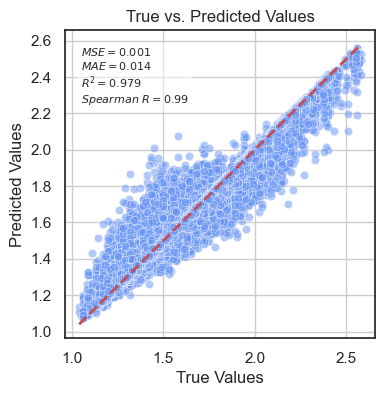

Evaluate on Test Set


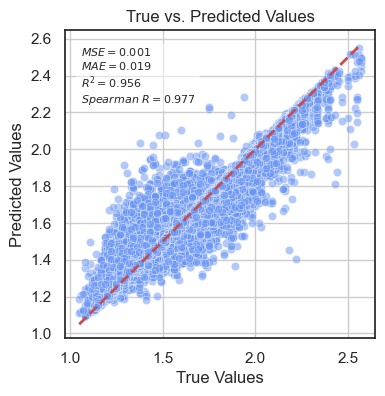

In [9]:
# Evaluate model on train and test set
utils.evaluate_best_regressor(model, X_train, y_train, dataset="Training", plot=True)
utils.evaluate_best_regressor(model, X_test, y_test, dataset="Test", plot=True)

In [10]:
# Save the model
data_and_model = [data_train, data_test, model]

file_data_model = f"../results/random_forest/model_and_data.pickle"
with open(file_data_model, 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

utils.get_model_size(model)

Model size on disk: 2.0660 GB


**Model Interpretation**

Interpretation on Training Set

In [ ]:
file_shap = f"../results/random_forest/train_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_train = pickle.load(handle)

In [ ]:
shap.plots.bar(explanation_train, max_display=17)

In [ ]:
shap.plots.beeswarm(explanation_train, max_display=17)

In [ ]:
utils.plot_shap_dependence(explanation_train)

Interpretation on Test Set

In [ ]:
file_shap = f"../results/random_forest/test_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_test = pickle.load(handle)

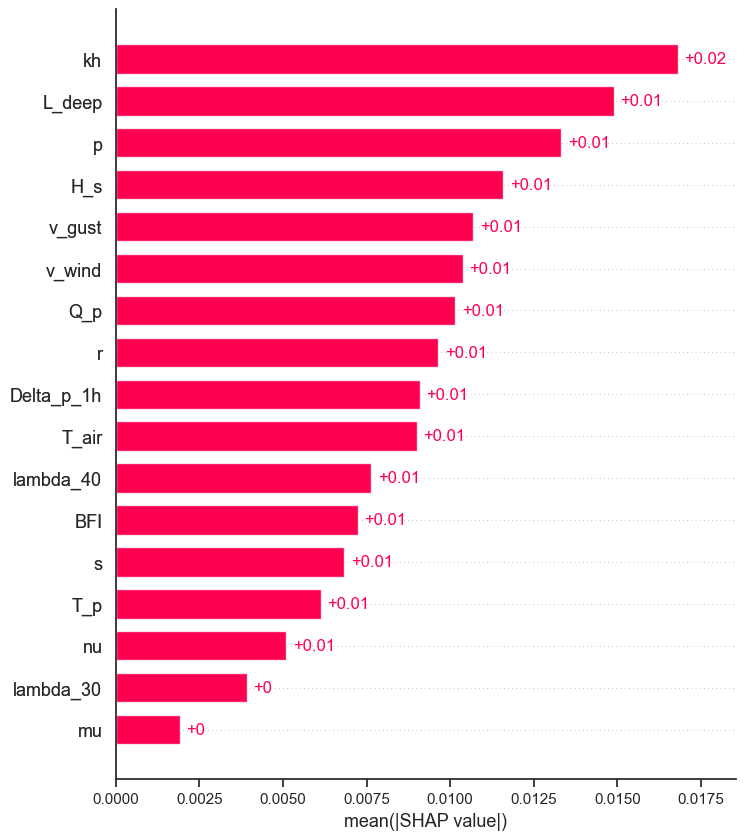

In [ ]:
shap.plots.bar(explanation_test, max_display=17)

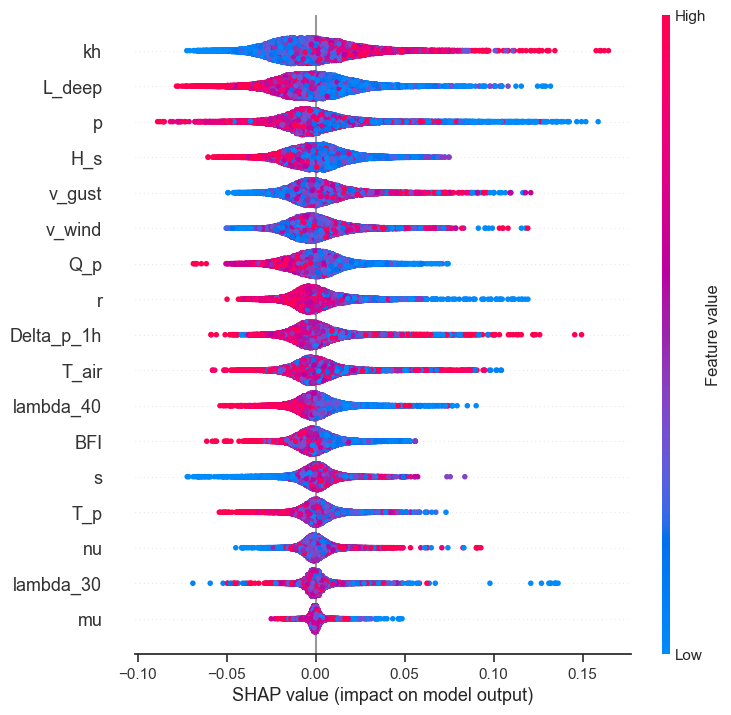

In [ ]:
shap.plots.beeswarm(explanation_test, max_display=17)

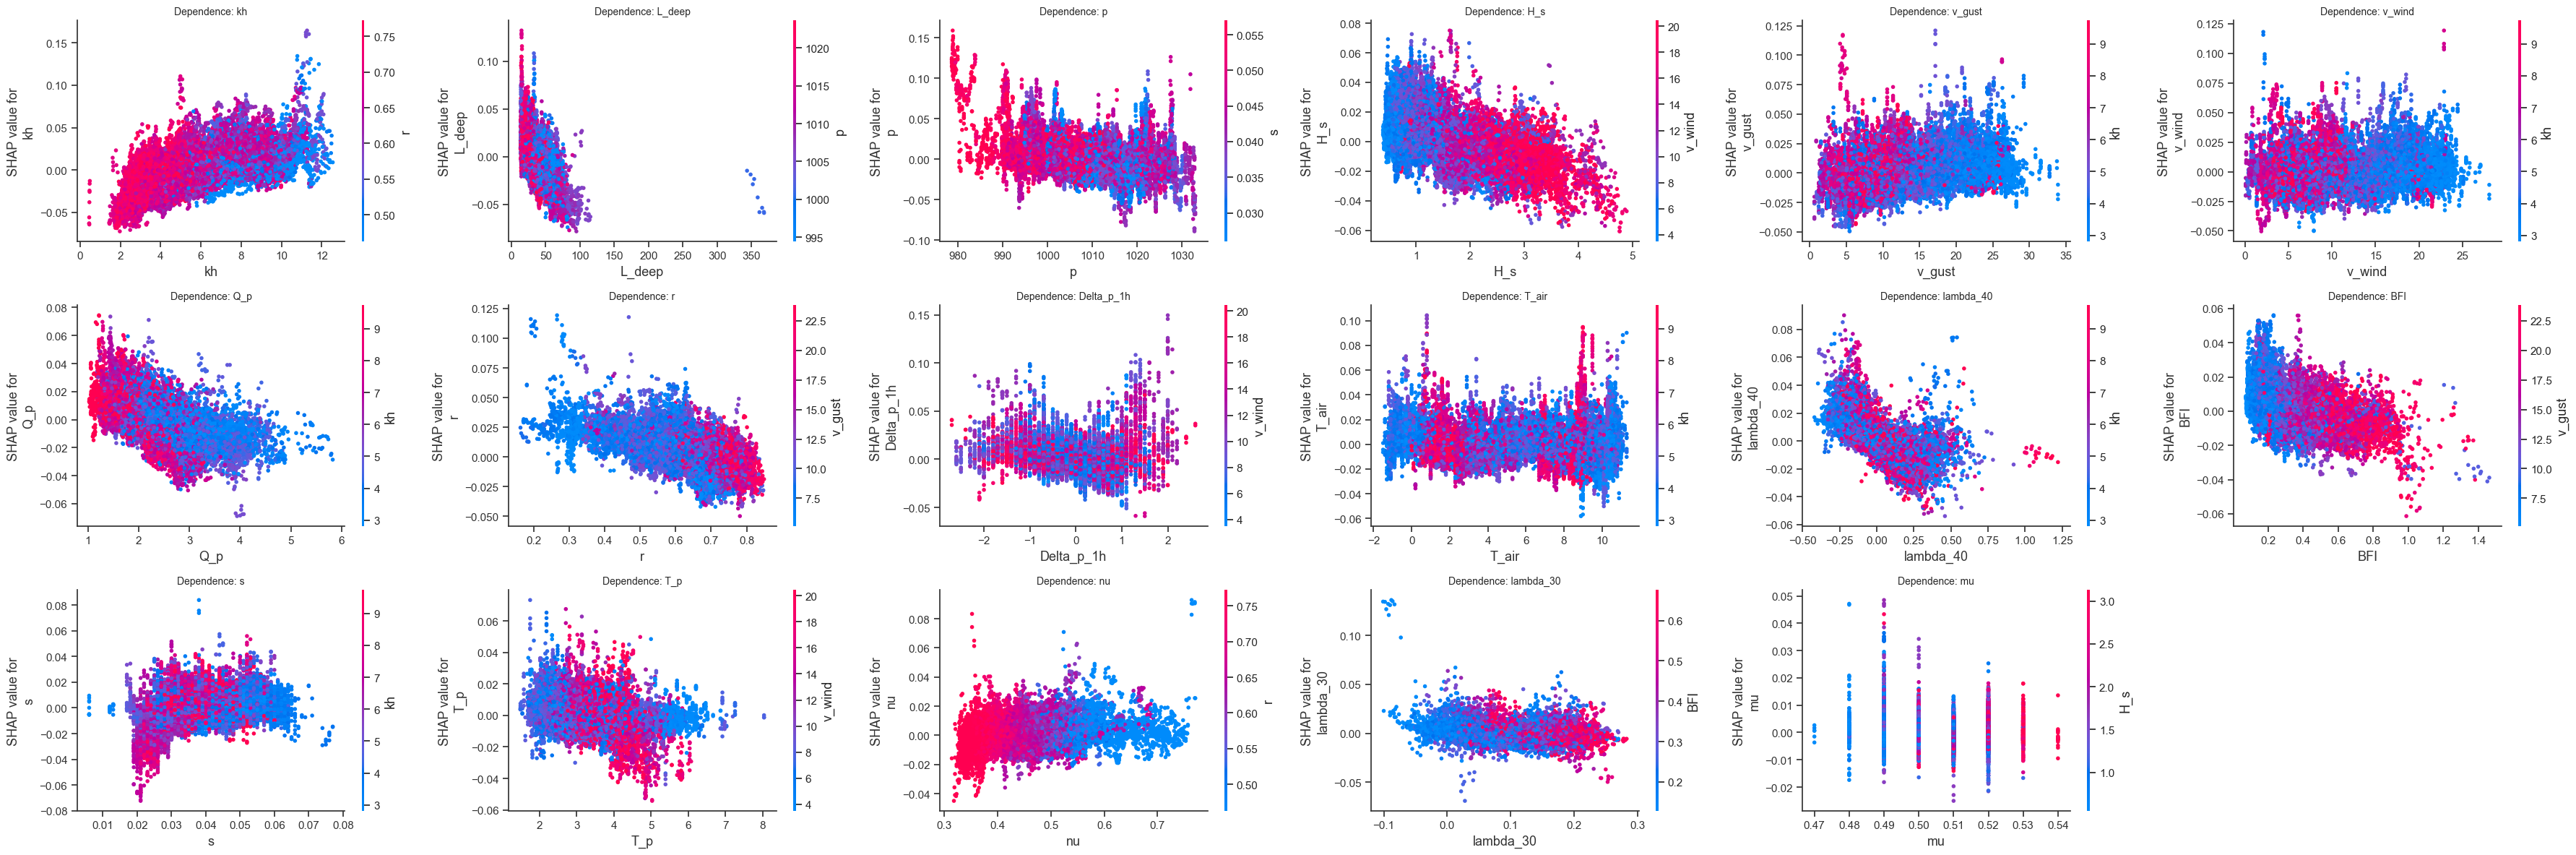

In [ ]:
utils.plot_shap_dependence(explanation_test)